## BUFR tropical cyclone example

The short notebook provides an example on how to read tropical cyclone track data from the ECMWF ensmble forecasting system.

- sample data from https://essential.ecmwf.int/
- python code to load BUFR data based on ecCodes example, see https://confluence.ecmwf.int/display/ECC/bufr_read_tropical_cyclone

As part of the example a basic analysis to calculate the tropical cyclone strike probability is performed and illustrated on a map.

First we need to set up the python environment and import the required modules:

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import LAND, OCEAN, COASTLINE
from datetime import datetime as dt, timedelta
from eccodes import codes_bufr_new_from_file, codes_set, codes_get, codes_get_array, codes_get_double, codes_get_long
from eccodes import CODES_MISSING_DOUBLE
from functools import partial
import json
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
import numpy as np
import pyproj
from shapely.geometry import shape, Point, MultiPoint
from shapely.ops import transform

Next we define some helper functions
- demo_load_cyclone_track: function to load ensemble of cyclone tracks from BUFR file.
- create_grid: function to create the analysis grid on which to calculate the strike probabilities.
- calculate_track_probabilities: function to calculate the strike probability based on the ensmeble of tracks and analsysis grid.

In [7]:
def demo_load_cyclone_track(filename):
    """
    Returns cyclone track information loaded from BUFR file.

    NOTE: THIS CODE IS PROVIDED FOR DEMONSTRATION PURPOSES AND SHOULD NOT BE USED OPERATIONALLY.

    Parameters
    ----------
    infile : string
        Path to the BUFR file containing the data to read.

    Returns
    -------
    stormIdentifier: string
        Identifier allocated to the storm.
    t0 : datetime
        Date and time of the forecast.
    deterministic : dictionary
        geojson type object containing the track as a MultiPoint feature, including sea level pressure (slp)
        and time step (datetime) as properties.
    objs : list
        List of geojson type objects, one per ensemble member. Each item as per deterministic but for the indicated ensemble member
    bounds : list
        Minimum and maximum longitude / latitude agregated across all ensemble members    
    """
    # set map bounds, this will be updated as part of reading the data
    bounds = [180,-180, 90, -90]
    # open and create bufr handle
    fh = open(filename,"rb")
    bufr = codes_bufr_new_from_file(fh)
    # unpack
    codes_set(bufr,"unpack",True)
    compressed = codes_get(bufr, 'compressedData')
    # get storm identifier
    stormIdentifier = codes_get(bufr, "stormIdentifier")
    # get number of subsets
    nSubsets = codes_get(bufr,"numberOfSubsets")
    # get date and time of T0
    year = codes_get(bufr,"#1#year")
    month = codes_get(bufr,"#1#month")
    day = codes_get(bufr,"#1#day")
    hour = codes_get(bufr,"#1#hour")
    minute = codes_get(bufr,"#1#minute")
    t0 = dt(year=year, month=month, day=day, hour=hour, minute=minute)
    # get location of low pressure centre at t0
    lon0 = [float(val) for val in codes_get_array(bufr,"#2#longitude")]
    if compressed and len(lon0) == 1 :
        lon0 = lon0 * nSubsets
    lat0 = [float(val) for val in codes_get_array(bufr,"#2#latitude")]
    if compressed and len(lat0) == 1 :
        lat0 = lat0 * nSubsets
    # and the pressure
    slp0 = [float(val) for val in codes_get_array(bufr,"#1#pressureReducedToMeanSeaLevel")]
    if compressed and len(slp0) == 1:
        slp0 = slp0*nSubsets
    # get time periods
    timePeriods = [float(val) for val in codes_get_array(bufr,"timePeriod")]
    numberTimesteps = len(timePeriods)
    
    # now extract a track for each subset
    objs = []
    deterministic = {
        "type": "Feature",
        "geometry": {
            "type": "MultiPoint",
            "coordinates": [ ]
        },
        "properties": {
            "stormIdentifier": stormIdentifier,
            "datetime": [ ],
            "slp": [ ]
        }        
    }
    subset = nSubsets - 1 # last ensemble member is deterministic
    if lat0[subset] == CODES_MISSING_DOUBLE or lon0[subset] == CODES_MISSING_DOUBLE or slp0[subset] == CODES_MISSING_DOUBLE:
            lat0[subset] = None
            lon0[subset] = None
            slp0[subset] = None
    else:
        deterministic['geometry']['coordinates'].append([lon0[subset], lat0[subset]])
        deterministic['properties']['datetime'].append(t0)
        deterministic['properties']['slp'].append(slp0[subset])
        bounds[0] = min(bounds[0], lon0[subset])
        bounds[1] = max(bounds[1], lon0[subset])
        bounds[2] = min(bounds[2], lat0[subset])
        bounds[3] = max(bounds[3], lat0[subset])
    
    for subset in range(nSubsets-2):
        objs.append( {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": []
                },
                "properties": {
                    "stormIdentifier": stormIdentifier,
                    "ensembleMember": subset,
                    "datetime": [],
                    "slp": []
                }        
            })    
        if lat0[subset] == CODES_MISSING_DOUBLE or lon0[subset] == CODES_MISSING_DOUBLE or slp0[subset] == CODES_MISSING_DOUBLE:
            lat0[subset] = None
            lon0[subset] = None
            slp0[subset] = None
            continue
        objs[subset]['geometry']['coordinates'].append([lon0[subset], lat0[subset]])
        objs[subset]['properties']['datetime'].append(t0)
        objs[subset]['properties']['slp'].append(slp0[subset])
        bounds[0] = min(bounds[0], lon0[subset])
        bounds[1] = max(bounds[1], lon0[subset])
        bounds[2] = min(bounds[2], lat0[subset])
        bounds[3] = max(bounds[3], lat0[subset])
        
    t = t0   
    for idx in range(numberTimesteps):
        indexNumber = (idx+1)*2 + 2    
        lat = [float(val) for val in codes_get_array(bufr, f"#{indexNumber:d}#latitude")]
        if compressed and len(lat) == 1:
            lat = lat*nSubsets    
        lon = [float(val) for val in codes_get_array(bufr, f"#{indexNumber:d}#longitude")]
        if compressed and len(lon) == 1:
            lon = lon*nSubsets        
        slp = [float(val) for val in codes_get_array(bufr, f"#{idx+2}#pressureReducedToMeanSeaLevel")]
        if compressed and len(slp) == 1:
            slp = slp*nSubsets    
        t = t0 + timedelta(hours=int(timePeriods[idx]))
        for subset in range(nSubsets-2):
            if lat[subset] == CODES_MISSING_DOUBLE or lon[subset] == CODES_MISSING_DOUBLE or slp[subset] == CODES_MISSING_DOUBLE:
                lat[subset] = None
                lon[subset] = None
                slp[subset] = None
            else:
                objs[subset]['geometry']['coordinates'].append(  [lon[subset], lat[subset]]  )
                objs[subset]['properties']['datetime'].append(t)
                objs[subset]['properties']['slp'].append(slp[subset])
                bounds[0] = min(bounds[0], lon[subset])
                bounds[1] = max(bounds[1], lon[subset])
                bounds[2] = min(bounds[2], lat[subset])
                bounds[3] = max(bounds[3], lat[subset])
    
        subset = nSubsets - 1 # last ensemble member is deterministic
        if lat[subset] == CODES_MISSING_DOUBLE or lon[subset] == CODES_MISSING_DOUBLE or slp[subset] == CODES_MISSING_DOUBLE:
                lat[subset] = None
                lon[subset] = None
                slp[subset] = None
        else:
            deterministic['geometry']['coordinates'].append([lon[subset], lat[subset]])
            deterministic['properties']['datetime'].append(t)
            deterministic['properties']['slp'].append(slp[subset])
            bounds[0] = min(bounds[0], lon[subset])
            bounds[1] = max(bounds[1], lon[subset])
            bounds[2] = min(bounds[2], lat[subset])
            bounds[3] = max(bounds[3], lat[subset])

    return stormIdentifier, t0, deterministic, objs, bounds


def create_grid(bounds, resolution): 
    """
    Returns latitudes and longutudes for a regular grid with bounds and resolution based on 
    input parameters.

    Parameters
    ----------
    bounds : list[float]
        List of minimum and maximum longitudes and latitudes [lon min, lon max, lat min, lat max]
    resolution: float
        Resolution on which to create the grid

    Returns
    -------
    grid_longitudes : array[float, float]
        Array of longitudes for grid box centres forming the grid.
    grid_latitudes : array[float, float]
        Array of latitudes for grid box centres forming the grid.
    
    """
    lons = np.arange(bounds[0], bounds[1] + resolution, resolution) 
    lats = np.arange(bounds[2], bounds[3] + resolution, resolution) 
    return np.meshgrid(lons, lats)


def calculate_track_probabilities(tracks, grid_lons, grid_lats, distance_threshold):
    """
    Demonstration showing a basic calculation of the probability that a tropical cyclone
    track will pass within a set distance of each grid point.

    NOTE: THIS CALCULAITON IS PROVIDED FOR DEMONSTRATION PURPOSES AND SHOULD NOT BE USED OPERATIONALLY

    Parameters
    ----------
    tracks : list[list]
        list of cyclone tracks from the ensemble. Each track is a list of MultiPoint objects giving the 
        position of the tropical cyclone centre at each timestep.
    grid_lons : array[float, float]
        List of longitudes for grid box centres forming the grid on which to perfrom the analysis.
    grid_lats : array[float, float]
        List of latitudes for grid box centres forming the grid on which to perfrom the analysis.
    distance_threshold : numeric
        Distance threshold (metres) to use in the calculation
        
    Returns
    -------
    probabilities : array[float,float]
        2 dimensional array showing the probability of the tropical cyclone track passing within the
        specified distance threshold.
        
    
    """
    # Create a geodetic distance calculator
    geod = pyproj.Geod(ellps='WGS84')
    # Create transformer objects
    wgs84 = pyproj.CRS('EPSG:4326')
    web_mercator = pyproj.CRS('EPSG:3857')
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    project_back = pyproj.Transformer.from_crs(web_mercator, wgs84, always_xy=True).transform
    
    # Function to create a buffer around a point
    def point_buffer(lon, lat):
        point = Point(lon, lat)
        point_projected = transform(project, point)
        buffer = point_projected.buffer(distance_threshold)
        return transform(project_back, buffer)

    probabilities = np.zeros_like(grid_lons)
    total_tracks = len(tracks)

    for i in range(grid_lons.shape[0]):
        for j in range(grid_lons.shape[1]):
            grid_point = Point(grid_lons[i, j], grid_lats[i, j])
            buffer = point_buffer(grid_lons[i, j], grid_lats[i, j])            
            tracks_within_buffer = sum(1 for track in tracks if buffer.intersects(track))
            probabilities[i, j] = tracks_within_buffer / total_tracks

    return probabilities

Now the functions are defined we can load the data and perform the analysis of tropical cyclone strike probability.

Note:
- The analysis grid resolution (in degrees lat/lon) is specified by the `resolution` variable below. The finer the resolution the longer the processing time.
- The distance threshold (in metres) is specified by the `distance_threshold` variable below. 

Note that the strike probability is calculated over all timesteps in the input BUFR file. 

In [10]:
# set path of file to process
infile = "./../notebooks/A_JSXX03ECEP010000_C_ECMP_20241001000000_tropical_cyclone_track_KIRK_-36p3degW_14p2degN_bufr4.bin"
# load the data
stormIdentifier, t0, deterministic, ensemble, bounds = demo_load_cyclone_track(infile)
# convert each trajectory into MultiPoint object
tracks = [MultiPoint(feature['geometry']['coordinates']) for feature in ensemble]
# grid on 0.1 degree grid
resolution = 0.1
# create grid
grid_lons, grid_lats = create_grid(np.add(bounds, [-5, 5, -5, 5]), resolution)
# set distance threshold (meters)
distance_threshold = 300000
# calculate probabilities
probabilities = calculate_track_probabilities(tracks, grid_lons, grid_lats, distance_threshold)

Now create the figure showing the strike probabilities

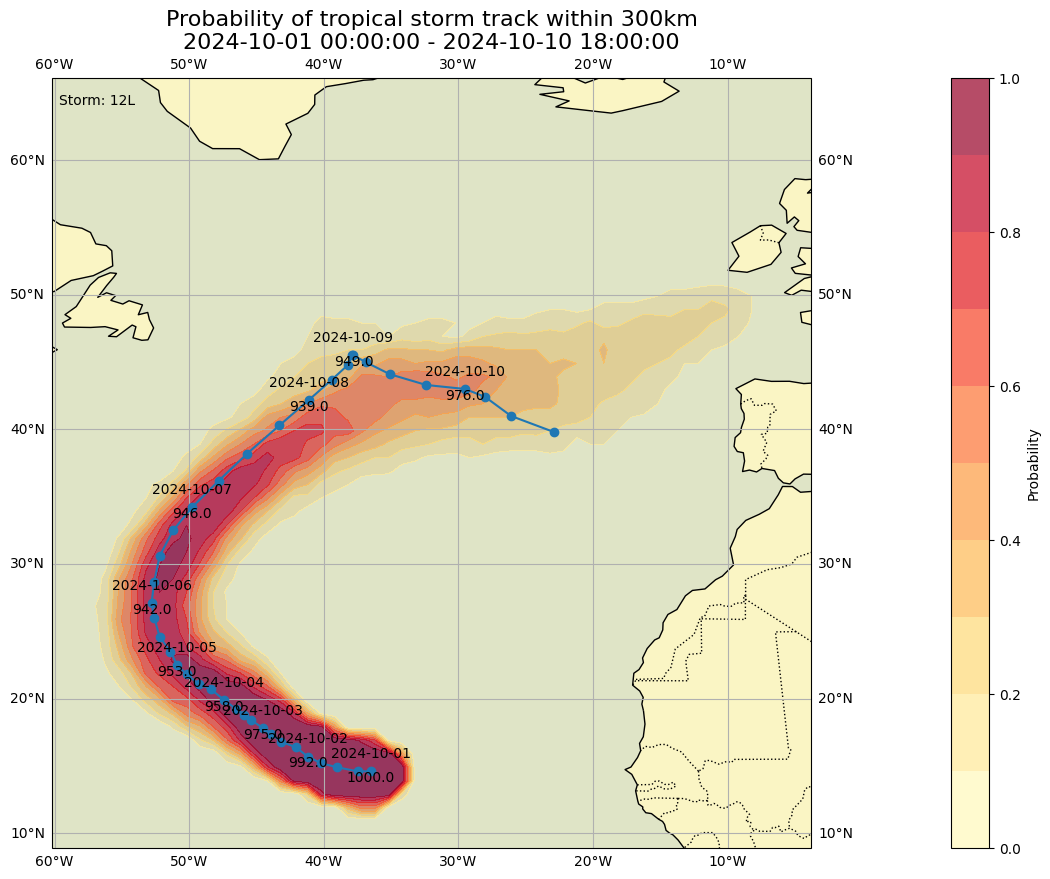

In [9]:
# now a new map showing the strike probabilities
fig, ax = plt.subplots(figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Set extent with 5 degree buffer
ax.set_extent( np.add(bounds,[-5,5,-5,5]), crs=ccrs.PlateCarree() )

# Add land, coastlines, etc.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Overlay probabilities
cs = ax.contourf(grid_lons, grid_lats, probabilities, levels=10, cmap='YlOrRd', transform=ccrs.PlateCarree(), alpha=0.7)

# Add colorbar
cbar = plt.colorbar(cs, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Probability')

# Add title and labels
t = deterministic['properties']['datetime'][-1]

plt.title(f'Probability of tropical storm track within {int(distance_threshold/1000)}km\n{t0} - {t}', fontsize=16)
plt.text(bounds[0]-4.5, bounds[3]+3, f"Storm: {stormIdentifier}")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Add deterministic track and pressures at midnight
lon, lat = zip( *deterministic['geometry']['coordinates'])

ax.plot(lon, lat, marker="o", transform=ccrs.PlateCarree())
for idx in range(len(lon)):
    if deterministic['properties']['datetime'][idx].hour == 0:
        plt.text(lon[idx], lat[idx]+1,deterministic['properties']['datetime'][idx].date(), horizontalalignment='center', transform=ccrs.PlateCarree() )
        plt.text(lon[idx], lat[idx]-1,deterministic['properties']['slp'][idx]/100.0, horizontalalignment='center', verticalalignment='bottom',transform=ccrs.PlateCarree() )

# now show
plt.show()